In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorcircuit as tc
from jax.config import config
from tqdm import tqdm
import os
from quimb import tensor

In [14]:
config.update("jax_enable_x64", True)
tc.set_backend("tensorflow")
tc.set_dtype("complex128")
tf.config.list_physical_devices('cuda: /gpu:0')

[]

In [15]:
def XXZ_energy(c: tc.Circuit, j: float = 0.25, hx: float = 0, delta: float = 0.125):
    e = 0.0
    n = c._nqubits
    for i in range(n - 1):
        e += (j * c.expectation((tc.gates.x(), [i]), (tc.gates.x(), [i + 1])) + j * c.expectation((tc.gates.y(), [i]), (
        tc.gates.y(), [i + 1])) + delta * c.expectation((tc.gates.z(), [i]), (tc.gates.z(), [i + 1])))
    for i in range(n):
        e -= hx * c.expectation((tc.gates.z(), [i]))
    return tc.backend.real(e)

In [16]:
def energy(c: tc.Circuit, j: float = 1.0, hx: float = 1.0):
    e = 0.0
    n = c._nqubits
    for i in range(n):
        e -= hx * c.expectation((tc.gates.x(), [i]))  # <X_i>
    for i in range(n - 1):
        e += j * c.expectation(
            (tc.gates.z(), [i]), (tc.gates.z(), [i + 1])
        )  # <Z_i Z_{i+1}>
    return tc.backend.real(e)

In [17]:
def MERA(params, n, hx):
    params = tc.backend.cast(params, "complex128")
    hx = tc.backend.cast(hx, "complex128")
    c = tc.Circuit(n)
    
    idx = 0
    
    # encoding layer
    for i in range(n):
        c.rx(i, theta=(params[4*i] * hx + params[4*i+1]))
        c.rz(i, theta=(params[4*i+2] * hx + params[4*i+1+3]))
    idx += 4*n
    
    for i in range(0, n-1, 2):
        c.cnot(i, i+1)
    
    for i in range(n):
        c.rx(i, theta=params[2*i])
        c.rz(i, theta=params[2*i+1])
    idx += 2*n
    
    
    # processing layer
    for n_layer in range(1, int(np.log2(n))+1):
        n_qubit = 2**n_layer   # 参与计算的qubit数
        step = int(n / n_qubit)

        # even    
        for i in range(step, n-step, 2*step):
            c.exp1(i, i+step, theta=params[idx], unitary=tc.gates._xx_matrix)
            c.exp1(i, i+step, theta=params[idx+1], unitary=tc.gates._zz_matrix)
            idx += 2
        
        # odd   
        for i in range(0, n, 2*step):
            c.exp1(i, i+step, theta=params[idx], unitary=tc.gates._xx_matrix)
            c.exp1(i, i+step, theta=params[idx+1], unitary=tc.gates._zz_matrix)
            idx += 2
        
        for i in range(0, n, step):
            c.rx(i, theta=params[idx])
            c.rz(i, theta=params[idx+1])
            idx += 2
        
        # c.barrier()

    # measure
    e = XXZ_energy(c, hx=hx)
    return e, c, idx

In [18]:
_, cirq, idx = MERA(np.zeros(1000), 8, 1)
print(idx)
cirq.draw()

98


┌───────┐┌───────┐     ┌───────┐┌───────┐┌───────┐┌───────┐┌───────┐»
q_0: ┤ Rx(0) ├┤ Rz(0) ├──■──┤ Rx(0) ├┤ Rz(0) ├┤1      ├┤1      ├┤ Rx(0) ├»
     ├───────┤├───────┤┌─┴─┐├───────┤├───────┤│       ││       │└───────┘»
q_1: ┤ Rx(0) ├┤ Rz(0) ├┤ X ├┤ Rx(0) ├┤ Rz(0) ├┤       ├┤       ├─────────»
     ├───────┤├───────┤└───┘├───────┤├───────┤│       ││       │         »
q_2: ┤ Rx(0) ├┤ Rz(0) ├──■──┤ Rx(0) ├┤ Rz(0) ├┤  exp1 ├┤  exp1 ├─────────»
     ├───────┤├───────┤┌─┴─┐├───────┤├───────┤│       ││       │         »
q_3: ┤ Rx(0) ├┤ Rz(0) ├┤ X ├┤ Rx(0) ├┤ Rz(0) ├┤       ├┤       ├─────────»
     ├───────┤├───────┤└───┘├───────┤├───────┤│       ││       │┌───────┐»
q_4: ┤ Rx(0) ├┤ Rz(0) ├──■──┤ Rx(0) ├┤ Rz(0) ├┤0      ├┤0      ├┤ Rx(0) ├»
     ├───────┤├───────┤┌─┴─┐├───────┤├───────┤└───────┘└───────┘└───────┘»
q_5: ┤ Rx(0) ├┤ Rz(0) ├┤ X ├┤ Rx(0) ├┤ Rz(0) ├───────────────────────────»
     ├───────┤├───────┤└───┘├───────┤├───────┤                           »
q_6: ┤ Rx(0) ├┤ Rz(0) ├──■──┤ Rx(0) ├┤ Rz(0) ├───────────────────────────»
     ├───────┤├───────┤┌─┴─┐├───────┤├───────┤                           »
q_7: ┤ Rx(0) ├┤ Rz(0) ├┤ X ├┤ Rx(0) ├┤ Rz(0) ├───────────────────────────»
     └───────┘└───────┘└───┘└───────┘└───────┘                           »
«     ┌───────┐                  ┌───────┐┌───────┐┌───────┐┌───────┐         »
«q_0: ┤ Rz(0) ├──────────────────┤1      ├┤1      ├┤ Rx(0) ├┤ Rz(0) ├─────────»
«     └───────┘                  │       ││       │└───────┘└───────┘┌───────┐»
«q_1: ───────────────────────────┤  exp1 ├┤  exp1 ├──────────────────┤1      ├»
«              ┌───────┐┌───────┐│       ││       │┌───────┐┌───────┐│  exp1 │»
«q_2: ─────────┤1      ├┤1      ├┤0      ├┤0      ├┤ Rx(0) ├┤ Rz(0) ├┤0      ├»
«              │       ││       │└───────┘└───────┘└───────┘└───────┘├───────┤»
«q_3: ─────────┤  exp1 ├┤  exp1 ├────────────────────────────────────┤1      ├»
«     ┌───────┐│       ││       │┌───────┐┌───────┐┌───────┐┌───────┐│  exp1 │»
«q_4: ┤ Rz(0) ├┤0      ├┤0      ├┤1      ├┤1      ├┤ Rx(0) ├┤ Rz(0) ├┤0      ├»
«     └───────┘└───────┘└───────┘│       ││       │└───────┘└───────┘├───────┤»
«q_5: ───────────────────────────┤  exp1 ├┤  exp1 ├──────────────────┤1      ├»
«                                │       ││       │┌───────┐┌───────┐│  exp1 │»
«q_6: ───────────────────────────┤0      ├┤0      ├┤ Rx(0) ├┤ Rz(0) ├┤0      ├»
«                                └───────┘└───────┘└───────┘└───────┘└───────┘»
«q_7: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«              ┌───────┐┌───────┐┌───────┐┌───────┐
«q_0: ─────────┤1      ├┤1      ├┤ Rx(0) ├┤ Rz(0) ├
«     ┌───────┐│  exp1 ││  exp1 │├───────┤├───────┤
«q_1: ┤1      ├┤0      ├┤0      ├┤ Rx(0) ├┤ Rz(0) ├
«     │  exp1 │├───────┤├───────┤├───────┤├───────┤
«q_2: ┤0      ├┤1      ├┤1      ├┤ Rx(0) ├┤ Rz(0) ├
«     ├───────┤│  exp1 ││  exp1 │├───────┤├───────┤
«q_3: ┤1      ├┤0      ├┤0      ├┤ Rx(0) ├┤ Rz(0) ├
«     │  exp1 │├───────┤├───────┤├───────┤├───────┤
«q_4: ┤0      ├┤1      ├┤1      ├┤ Rx(0) ├┤ Rz(0) ├
«     ├───────┤│  exp1 ││  exp1 │├───────┤├───────┤
«q_5: ┤1      ├┤0      ├┤0      ├┤ Rx(0) ├┤ Rz(0) ├
«     │  exp1 │├───────┤├───────┤├───────┤├───────┤
«q_6: ┤0      ├┤1      ├┤1      ├┤ Rx(0) ├┤ Rz(0) ├
«     └───────┘│  exp1 ││  exp1 │├───────┤├───────┤
«q_7: ─────────┤0      ├┤0      ├┤ Rx(0) ├┤ Rz(0) ├
«              └───────┘└───────┘└───────┘└───────┘

In [19]:
def meta_MERA(params, n, hx):
    e_all = tf.zeros([1], dtype=tf.float64)
    for h in hx:
        e, _, idx = MERA(params, n, h)
        e_all += e

    return e_all

In [20]:
meta_MERA_tfim_vvag = tc.backend.jit(
    tc.backend.vectorized_value_and_grad(meta_MERA)
)

In [21]:
def batched_train(n, hz, batch=10, maxiter=10000, lr=0.005):
    params = tf.Variable(
        initial_value=tf.random.normal(
            shape=[batch, idx], stddev=1, dtype=getattr(tf, tc.rdtypestr)
        )
    )
    opt = tf.keras.optimizers.Adam(lr)
    lowest_energy = 1e5
    best_params = None
    for i in range(maxiter):
        e, grad = meta_MERA_tfim_vvag(params, n, hz)
        opt.apply_gradients([(grad, params)])
        if tf.reduce_min(e) < lowest_energy:
            lowest_energy = tf.reduce_min(e)
            best_params = params[tf.argmin(e).numpy()[0]]
        if i % 200 == 0:
            print(e)
    return lowest_energy, best_params

In [22]:
n = 8

energy_DMRG = []
for i in np.linspace(0, 1.6, 17):
    h = tensor.tensor_gen.MPO_ham_XXZ(n, delta=0.5, jxy=1.0, S=0.5, bz=2 * i, cyclic=False)  
    dmrg = tensor.tensor_dmrg.DMRG(h, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-13)
    dmrg.solve(tol=1e-9, verbosity=0)
    energy_DMRG.append(dmrg.energy)

In [27]:
hx = tf.random.uniform(
    shape=[10], minval=0, maxval=1.6, dtype=getattr(tf, tc.rdtypestr)
)

meta_energy, best_params = batched_train(n, hx, batch=5, maxiter=5000, lr=0.007)

test_hx = tf.random.uniform(
    shape=[100], minval=0, maxval=1.6, dtype=getattr(tf, tc.rdtypestr)
)
test_energies = tf.zeros_like(test_hx).numpy()

for i, h in enumerate(test_hx):
    _, c, idx = MERA(best_params, n, h)
    test_energies[i] = XXZ_energy(c, hx=tc.backend.cast(h, "complex128")).numpy()

tf.Tensor(
[[ 7.16130098]
 [-5.4358075 ]
 [-4.45823532]
 [-6.88414369]
 [ 5.2153983 ]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-51.23422542]
 [-52.66510135]
 [-48.45850295]
 [-50.40901977]
 [-48.25553855]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-52.93534585]
 [-54.20643276]
 [-51.98484517]
 [-53.6728611 ]
 [-52.55173731]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-53.81247553]
 [-54.42886763]
 [-52.90041069]
 [-54.4047798 ]
 [-53.85694297]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-54.24515382]
 [-54.49587037]
 [-54.0171628 ]
 [-54.61539351]
 [-54.08245745]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-54.48296807]
 [-54.56004337]
 [-54.20364192]
 [-54.73837063]
 [-54.20907868]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-54.68252039]
 [-54.86000245]
 [-54.33503361]
 [-54.82657681]
 [-54.30995214]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-54.77277153]
 [-55.07273473]
 [-54.40860482]
 [-54.91734988]
 [-54.35735302]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[-54.7949228 ]
 [

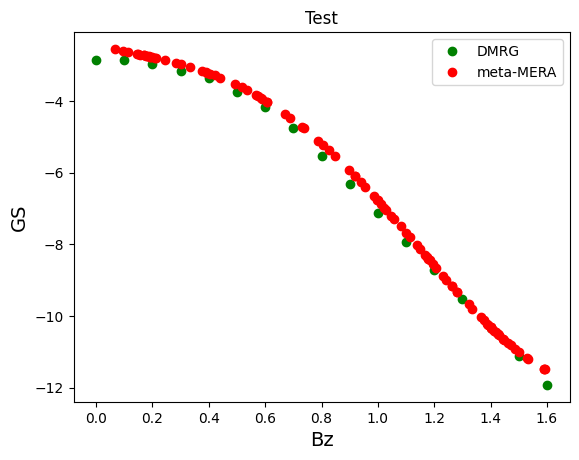

In [28]:
plt.plot(np.linspace(0, 1.6, 17), energy_DMRG, 'go', label='DMRG')
plt.plot(test_hx, test_energies, 'ro', label='meta-MERA')
plt.title("Test")
plt.xlabel("Bz", fontsize=14)
plt.ylabel("GS", fontsize=14)
plt.legend()
plt.show()